In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

### Data Visualization

In [11]:
path = "Images"
annotation = "Airplanes_Annotations"

def visualization():
    for e,i in enumerate(os.listdir(annotation)):
        if e < 10:
            filename = i.split(".")[0]+".jpg"
            print(filename)
            img = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annotation,i))
            plt.imshow(img)
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
            plt.figure()
            plt.imshow(img)
            break


airplane_062.jpg


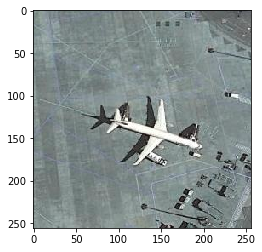

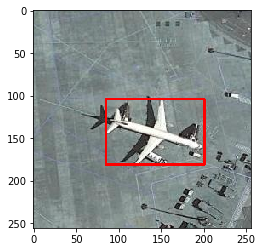

In [4]:
visualization()

### Using built-In selective search method

In [13]:
cv2.setUseOptimized(True);
selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

(266, 4)
0 190 82 66
6 168 87 74
217 85 30 31
90 128 33 12
150 245 16 11
9 188 31 23
49 85 22 15
48 71 86 75
30 168 61 71
240 223 16 33
3 0 92 198
150 246 16 10
181 16 37 29
0 186 82 70
156 244 24 12
216 54 15 19
246 239 10 17
48 77 86 82
50 102 31 19
26 221 20 25
9 168 72 71
193 189 22 12
26 220 24 26
88 117 37 22
55 0 177 157
167 154 89 102
80 229 14 27
176 193 24 26
37 168 23 29
80 231 17 25
67 118 9 44
122 139 14 29
88 120 36 21
50 75 87 90
201 46 30 27
48 71 53 36
71 76 29 33
0 209 83 47
147 244 33 12
201 13 24 39
165 244 15 12
176 31 26 17
170 85 86 171
0 188 82 68
221 43 21 17
0 209 82 47
73 75 64 90
196 115 57 26
173 117 83 139
187 123 23 25
201 150 23 24
0 186 38 38
51 102 23 10
179 24 37 18
66 71 35 36
167 171 43 82
9 168 87 88
51 177 14 29
176 185 24 34
147 85 109 171
221 38 11 21
175 10 49 21
8 0 248 256
176 125 80 131
72 129 20 33
41 210 40 23
0 0 89 194
176 154 80 102
73 210 18 24
72 133 21 30
94 88 12 28
47 197 46 35
42 207 39 26
0 0 95 251
142 85 114 171
55 174 36 44
20

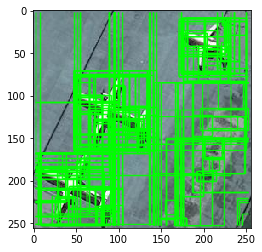

In [15]:
im = cv2.imread(os.path.join(path,"airplane_001.jpg"))
selective_search.setBaseImage(im)
selective_search.switchToSelectiveSearchFast()
rects = selective_search.process()
imOut = im.copy()
#print(rects.shape)
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    #print(x,y,w,h)
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [7]:
train_images=[]
train_labels=[]

### Intersection over union(IOU)
##### Intersection over Union is an evaluation metric used to measure the accuracy of an object detector on a particular dataset.Any algorithm that provides predicted bounding boxes as output can be evaluated using IoU.

##### More formally, in order to apply Intersection over Union to evaluate an (arbitrary) object detector we need:
###### 1) The ground-truth bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).
###### 2) The predicted bounding boxes from our model.


###### IoU = Area of  Overlap(intesection) / Area of Union(Union)

In [8]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [7]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [10]:
for e,i in enumerate(os.listdir(annotation)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annotation,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_062.jpg
inside
1 airplane_028.jpg
2 airplane_094.jpg
3 airplane_024.jpg
4 airplane_032.jpg
5 airplane_022.jpg
6 airplane_100.jpg
7 airplane_041.jpg
inside
8 airplane_097.jpg
inside
9 airplane_036.jpg
10 airplane_099.jpg
11 airplane_018.jpg
12 airplane_072.jpg
13 airplane_043.jpg
14 airplane_057.jpg
15 airplane_079.jpg
16 airplane_058.jpg
17 airplane_083.jpg
inside
18 airplane_084.jpg
19 airplane_065.jpg
20 airplane_031.jpg
21 airplane_014.jpg
22 airplane_008.jpg
23 airplane_030.jpg
24 airplane_033.jpg
25 airplane_042.jpg
26 airplane_013.jpg
27 airplane_053.jpg
inside
28 airplane_087.jpg
29 airplane_050.jpg
30 airplane_044.jpg
31 airplane_092.jpg
32 airplane_004.jpg
inside
33 airplane_001.jpg
inside
34 airplane_039.jpg
35 airplane_038.jpg
36 airplane_003.jpg
37 airplane_009.jpg
38 airplane_011.jpg
39 airplane_080.jpg
40 airplane_016.jpg
41 airplane_098.jpg
42 airplane_078.jpg
43 airplane_077.jpg
44 airplane_066.jpg
45 airplane_049.jpg
46 airplane_046.jpg
47 airplane_068.jpg
4

In [11]:
x_train = np.array(train_images)
y_train = np.array(train_labels)

### VGG19 model

In [12]:
vgg = VGG19(weights='imagenet', include_top=True)

In [13]:
for layers in (vgg.layers)[:15]:
    print(layers)
    layers.trainable = False


In [14]:
X = vgg.layers[-2].output

In [15]:
predictions = Dense(2, activation="softmax")(X)

In [16]:
model = Model(inputs = vgg.input, outputs = predictions)
opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
checkpoint = ModelCheckpoint("rcnn_vgg19_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [19]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [20]:
lenc = MyLabelBinarizer()
y_train =  lenc.fit_transform(y_train)

In [21]:
X_train, X_test , y_train, y_test = train_test_split(x_train,y_train,test_size=0.10)

In [22]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3971, 224, 224, 3) (442, 224, 224, 3) (3971, 2) (442, 2)


In [1]:
#hist = model.fit(X_train, y_train, epochs= 1000, validation_data= (X_test, y_test), validation_steps=2, callbacks=[checkpoint,early])

In [9]:
test_path = 'test/airplane_666.jpg'


In [3]:
model = load_model('model/rcnn.h5')


### Prediction

5.2437813e-06
3.8633207e-05
0.68521595
2.2925824e-05
3.4809727e-06
4.9028126e-06
0.0014485097
3.3936562e-06
2.8180064e-06
0.65415174
0.62611544
0.005429448
0.05033781
0.00029455638
0.001219087
4.4302186e-07
2.71887e-06
1.19046035e-05
0.00013332284
8.662403e-07
4.835016e-05
0.00037725057
3.158376e-09
5.5961677e-06
0.08811312
2.394145e-05
1.7184963e-07
3.7034624e-09
0.014780754
0.017250123
0.0034787152
2.6805147e-09
0.2559646
1.5704524e-09
2.7499194e-08
0.0040146606
1.2217855e-08
8.127554e-07
3.4068473e-06
8.1152314e-07
0.0068400097
8.346735e-07
2.991009e-09
0.00023269682
1.4982254e-08
0.6344195
2.0339914e-07
0.009727695
0.023519935
1.9442693e-08
4.9983373e-09
0.72525114
9.785263e-07
0.054624163
6.772783e-06
2.757678e-06
3.1939484e-09
4.768758e-08
1.6688842e-08
9.434153e-07
0.12933083
0.7036275
9.647838e-06
6.404656e-06
2.2625706e-07
0.06156837
2.4058494e-07
0.66170543
7.1310587e-06
3.503119e-09
2.47662e-07
4.025842e-06
0.7246645
0.0004135823
1.1857115e-06
9.095538e-09
2.27984e-07
2.4996

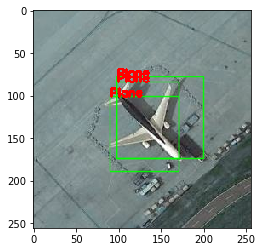

In [20]:
img = cv2.imread(test_path)
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model.predict(img)
        print(out[0][0])
        if out[0][0] > 0.7:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            cv2.putText(imout, "Plane", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 0), 2)
plt.figure()
plt.imshow(imout)